<a href="https://colab.research.google.com/github/aivrm/ai/blob/main/GD_2_%EC%97%86%EB%8B%A4%EB%A9%B4_%EC%96%B4%EB%96%BB%EA%B2%8C_%EB%90%A0%EA%B9%8C%3F_(ResNet_Ablation_Study)(BAT32_EP10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.14


In [ ]:
pip show tensorflow-datasets

Name: tensorflow-datasets
Version: 4.6.0
Summary: tensorflow/datasets is a library of datasets ready to use with TensorFlow.
Home-page: https://github.com/tensorflow/datasets
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: termcolor, typing-extensions, absl-py, tqdm, etils, numpy, promise, requests, protobuf, six, toml, dill, tensorflow-metadata, importlib-resources
Required-by: 


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_test, ds_train), ds_info = tfds.load(   name='cats_vs_dogs',
                                            #split=('train', 'test'),
                                            #split=('train[:35%]', 'train[20%:]'),
                                            split=('train[:80%]', 'train[80%:]'),
                                            #split=('train[:10%]', 'train[10%:20%]'),
                                            as_supervised=True,
                                            shuffle_files=True,
                                            with_info=True,
                                        )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteQJ4MMS/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(4652, shape=(), dtype=int64)
tf.Tensor(18610, shape=(), dtype=int64)


In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])  # 사이즈 조절
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

2

In [ ]:
ds_info.features["label"].names

['cat', 'dog']

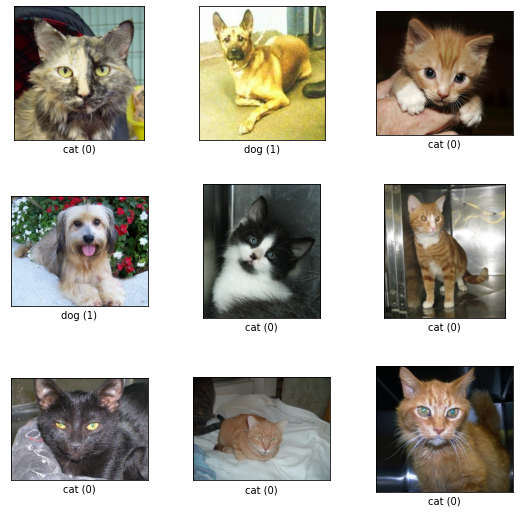

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

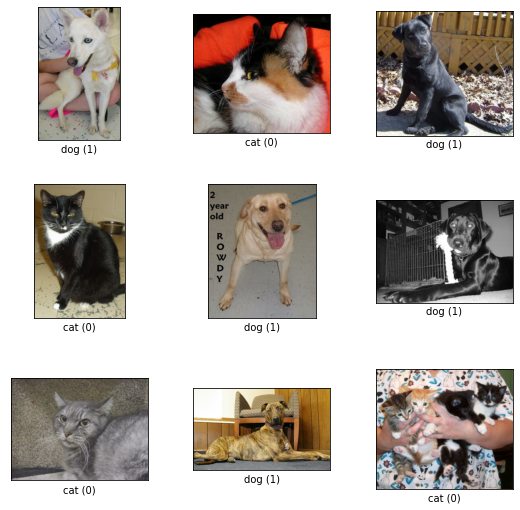

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

In [ ]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                       num_cnn=3,
                       channel=64,
                       block_num=1,
                       is_50 = False,
                       is_plain = False
                      ):
    # 입력 레이어
    x = input_layer

    if not is_50:

        # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3,3),
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    padding='same',
                                    name=f'block{block_num}_1_conv{cnn_num}'
            )(x)

            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
                # skip connection
                x = keras.layers.Add()([x,identity])
            else:
                pass

    else:

        identity = x
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(1,1),
                                activation='relu',
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                activation='relu',
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(filters=channel * 4,
                                kernel_size=(1,1),
                                activation='relu',
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_conv{cnn_num}'
        )(x)

        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
            # skip connection
            x = keras.layers.Add()([x,identity])
        else:
            pass

        # Max Pooling 레이어
        # 마지막 블록 뒤에는 pooling을 하지 않음
        if identity.shape[1] != 1:
            x = keras.layers.MaxPooling2D(
                pool_size=(2, 2),
                strides=2,
                name=f'block{block_num}_pooling'
            )(x)

    return x

In [ ]:
resnet_input_layer = keras.layers.Input(shape=(224,224,3))   # 입력 레이어 생성
resnet_block_output = build_resnet_block(resnet_input_layer)  # ResNet 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv0 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['block1_conv0[0][0]']           
 alization)                     )                                                             

In [ ]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(224,224,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2,
                 is_50 = False,
                 is_plain = False
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 2
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # conv1층
    output = keras.layers.Conv2D(filters=64,
                                 kernel_size = (7,7),
                                 strides = 2,
                                 padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)

    # conmv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (3,3),
                                       strides = 2,)(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 ResNet 모델을 만들면 ResNet-34가 됩니다.
#resnet_34 = build_resnet(is_50 = False)
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)

resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 109, 109, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 109, 109, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

In [ ]:
# 기본값을 그대로 사용해서 ResNet 모델을 만들면 ResNet-34가 되지만,
# is_50=True 로 하면, ResNet-50 이 됨.
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)

resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 109, 109, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 109, 109, 64  256        ['conv2d_5[0][0]']               
 ormalization)                  )                                                           

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_50 = build_resnet(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512],
    is_50=True
)

resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 109, 109, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 109, 109, 64  256        ['conv2d_9[0][0]']               
 ormalization)                  )                                                           

In [ ]:
# skip connection 이 없는 일반 네트워크(plain net)
def build_plainnet(input_shape=(224,224,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2,
                 is_50 = False,
                 is_plain = False
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 2
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # conv1층
    output = keras.layers.Conv2D(filters=64,
                                 kernel_size = (7,7),
                                 strides = 2,
                                 padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)

    # conmv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (3,3),
                                       strides = 2,
    )(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_plain = True  # 333
        )
        
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# skip connection이 없는 PlainNet-34
plainnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)

plainnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 109, 109, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 109, 109, 64  256        ['conv2d_13[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# skip connection이 없는 PlainNet-50
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)

plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)      9472      
                                                                 
 batch_normalization_71 (Bat  (None, 109, 109, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 block0_conv0 (Conv2D)       (None, 54, 54, 64)        36928     
                                                                 
 batch_normalization_72 (Bat  (None, 54, 54, 64)       256 

In [ ]:
BATCH_SIZE = 32
EPOCH = 10

In [ ]:
'''
(ds_test, ds_train), ds_info = tfds.load(   name='cats_vs_dogs',
                                            #split=('train', 'test'),
                                            #split=('train[:35%]', 'train[20%:]'),
                                            split=('train[:80%]', 'train[80%:]'),
                                            as_supervised=True,
                                            shuffle_files=True,
                                            with_info=True,
                                        )
'''
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 455s 742ms/step - loss: 0.9462 - accuracy: 0.6750 - val_loss: 0.8289 - val_accuracy: 0.6358
Epoch 2/10
581/581 [==============================] - 424s 730ms/step - loss: 0.2004 - accuracy: 0.9191 - val_loss: 0.9160 - val_accuracy: 0.7067
Epoch 3/10
581/581 [==============================] - 425s 731ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 1.4153 - val_accuracy: 0.6972
Epoch 4/10
581/581 [==============================] - 424s 729ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 1.2581 - val_accuracy: 0.7293
Epoch 5/10
581/581 [==============================] - 424s 730ms/step - loss: 6.4439e-05 - accuracy: 1.0000 - val_loss: 1.3230 - val_accuracy: 0.7317
Epoch 6/10
581/581 [==============================] - 424s 731ms/step - loss: 7.2104e-05 - accuracy: 1.0000 - val_loss: 1.4157 - val_accuracy: 0.7233
Epoch 7/10
581/581 [==============================] - 424s 730ms/step - loss: 2.4304e-05 - accuracy: 1.0000 - val_lo

In [ ]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain34 = plainnet_34.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    #steps_per_epoch=int(ds_info.splits['train[:10%]'].num_examples/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['train[10%:50%]'].num_examples/BATCH_SIZE),
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 435s 731ms/step - loss: 0.8965 - accuracy: 0.6588 - val_loss: 0.6416 - val_accuracy: 0.6815
Epoch 2/10
581/581 [==============================] - 424s 730ms/step - loss: 0.2470 - accuracy: 0.8965 - val_loss: 0.9016 - val_accuracy: 0.6989
Epoch 3/10
581/581 [==============================] - 424s 729ms/step - loss: 0.0447 - accuracy: 0.9849 - val_loss: 1.1751 - val_accuracy: 0.7203
Epoch 4/10
581/581 [==============================] - 424s 730ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 1.1532 - val_accuracy: 0.7386
Epoch 5/10
581/581 [==============================] - 424s 730ms/step - loss: 1.8291e-04 - accuracy: 1.0000 - val_loss: 1.3187 - val_accuracy: 0.7416
Epoch 6/10
581/581 [==============================] - 423s 729ms/step - loss: 4.0549e-05 - accuracy: 1.0000 - val_loss: 1.3206 - val_accuracy: 0.7343
Epoch 7/10
581/581 [==============================] - 425s 731ms/step - loss: 2.9482e-05 - accuracy: 1.0000 - val_lo

In [ ]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain50 = plainnet_50.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 414s 697ms/step - loss: 0.7232 - accuracy: 0.5217 - val_loss: 0.7086 - val_accuracy: 0.5213
Epoch 2/10
581/581 [==============================] - 404s 695ms/step - loss: 0.6882 - accuracy: 0.5478 - val_loss: 0.8944 - val_accuracy: 0.5485
Epoch 3/10
581/581 [==============================] - 405s 697ms/step - loss: 0.6773 - accuracy: 0.5686 - val_loss: 0.8231 - val_accuracy: 0.5627
Epoch 4/10
581/581 [==============================] - 403s 694ms/step - loss: 0.6605 - accuracy: 0.6053 - val_loss: 0.6718 - val_accuracy: 0.5942
Epoch 5/10
581/581 [==============================] - 405s 698ms/step - loss: 0.6212 - accuracy: 0.6500 - val_loss: 0.9042 - val_accuracy: 0.5328
Epoch 6/10
581/581 [==============================] - 403s 694ms/step - loss: 0.5895 - accuracy: 0.6869 - val_loss: 0.7418 - val_accuracy: 0.6265
Epoch 7/10
581/581 [==============================] - 405s 696ms/step - loss: 0.5673 - accuracy: 0.7007 - val_loss: 0.9430 -

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    #UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    #steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    #validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 434s 731ms/step - loss: 0.9951 - accuracy: 0.6402 - val_loss: 0.6622 - val_accuracy: 0.6179
Epoch 2/10
581/581 [==============================] - 424s 730ms/step - loss: 0.3043 - accuracy: 0.8680 - val_loss: 0.8363 - val_accuracy: 0.6938
Epoch 3/10
581/581 [==============================] - 425s 731ms/step - loss: 0.0533 - accuracy: 0.9826 - val_loss: 1.1458 - val_accuracy: 0.7032
Epoch 4/10
581/581 [==============================] - 424s 730ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 1.3038 - val_accuracy: 0.7347
Epoch 5/10
581/581 [==============================] - 423s 729ms/step - loss: 2.0590e-04 - accuracy: 1.0000 - val_loss: 1.2814 - val_accuracy: 0.7386
Epoch 6/10
581/581 [==============================] - 424s 730ms/step - loss: 4.7258e-05 - accuracy: 1.0000 - val_loss: 1.2833 - val_accuracy: 0.7390
Epoch 7/10
581/581 [==============================] - 424s 730ms/step - loss: 2.4351e-05 - accuracy: 1.0000 - val_lo

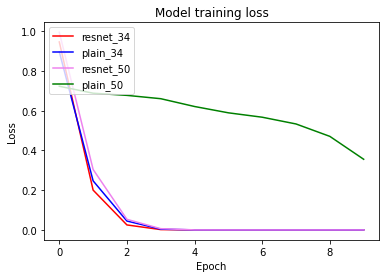

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'b')
plt.plot(history_50.history['loss'], color='violet')
plt.plot(history_plain50.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'resnet_50', 'plain_50'], loc='upper left')
plt.show()

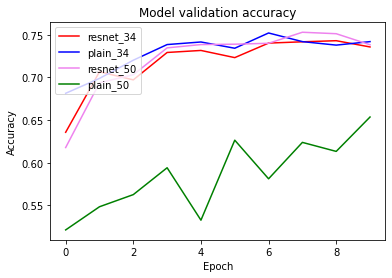

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], color='violet')
plt.plot(history_plain50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'resnet_50', 'plain_50'], loc='upper left')
plt.show()

### 회고

BATCH_SIZE = 256, 128, 64 에서,<br>
"사용 가능한 RAM을 모두 사용한 후 세션이 다운되었습니다." 또는<br>
다른 메시지를 출력하며 중단되었습니다.<br>
<br>
그래서, training data 중 일부만 사용하고,<br>
BATCH_SIZE = 32 로 돌렸더니 중단되지 않았습니다.<br>
실험 중에,<br>
BATCH_SIZE = 16 일 때 보다, BATCH_SIZE = 32 에서 빨리 처리되는 경우도 있었습니다.<br>
* BATCH_SIZE = 16 일 때는, 1 EPOCH 당 480 ~ 500초대.<br>
* BATCH_SIZE = 32 일 때는, 1 EPOCH 당 100 ~ 120초대.<br>

그래서, BATCH_SIZE = 16 일 때 보다, 32 일 때가 성능이 좋았다고 결론을 지으려고 했었으나,<br>
일시적인 현상으로,<br>
아마 GPU가 잘 걸렸던 것으로 추정됩니다.<br>
<br>
plain_50 이 현격히 성능이 저하되는 것을 확인하였으나,<br>
소스에도 문제가 있기 때문에,<br>
계속 수정하면서, plain_30 에서도 확인해 보겠습니다.